# DDPG
Deep Deterministic Policy Gradient (DDPG) adapts the ideas of Deep Q-learning to the continuous action domain. DDPG is a model-free actor-critic algorithm that is based on the deterministic policy gradient (DPG) algorithm. DDPG was shown to match and surpass state of the art RL algorithms in the continuous action space environments and tasks including those policies found through planning with full access to environment dynamics.

In order to adapt to continuous action spaces, it is no longer possible directly apply Q-learning due to the exponentially mapping from state to action space. Instead, DDPG uses an actor-critic setup with neural non-linear approximators to represent the actor policy network that maps from states to actions and and the critic network that maps state action 2-tuples to Q value similar to in Q-learning.

The challenge with training neural approximators is that most optimization algorithms assume that the samples are sampled indepentally and identically distributed (i.i.d). Hence, DDPG maintains a replay buffer of transitions to sample from which enables batch training to stabailize neural network training as well as alleviate the issue of i.i.d sampling.

To improve stability of training and prevent divergence, DDPG employs soft target network updates rather than directly copying updated weights. This is done by keeping a copy of the actor and critic networks which are updated slowly based on the gradient of the original actor and critic networks. It should be noted that this does slow down training as signal needs to be propogated over time from gradient updates to the actor and critic copies but this is essential to stabalize updates and training while preventing divergent behavior.

Lastly, DDPG tackles the problem of exploration in continuous action spaces by separately adding some noise to the actors actions during training.


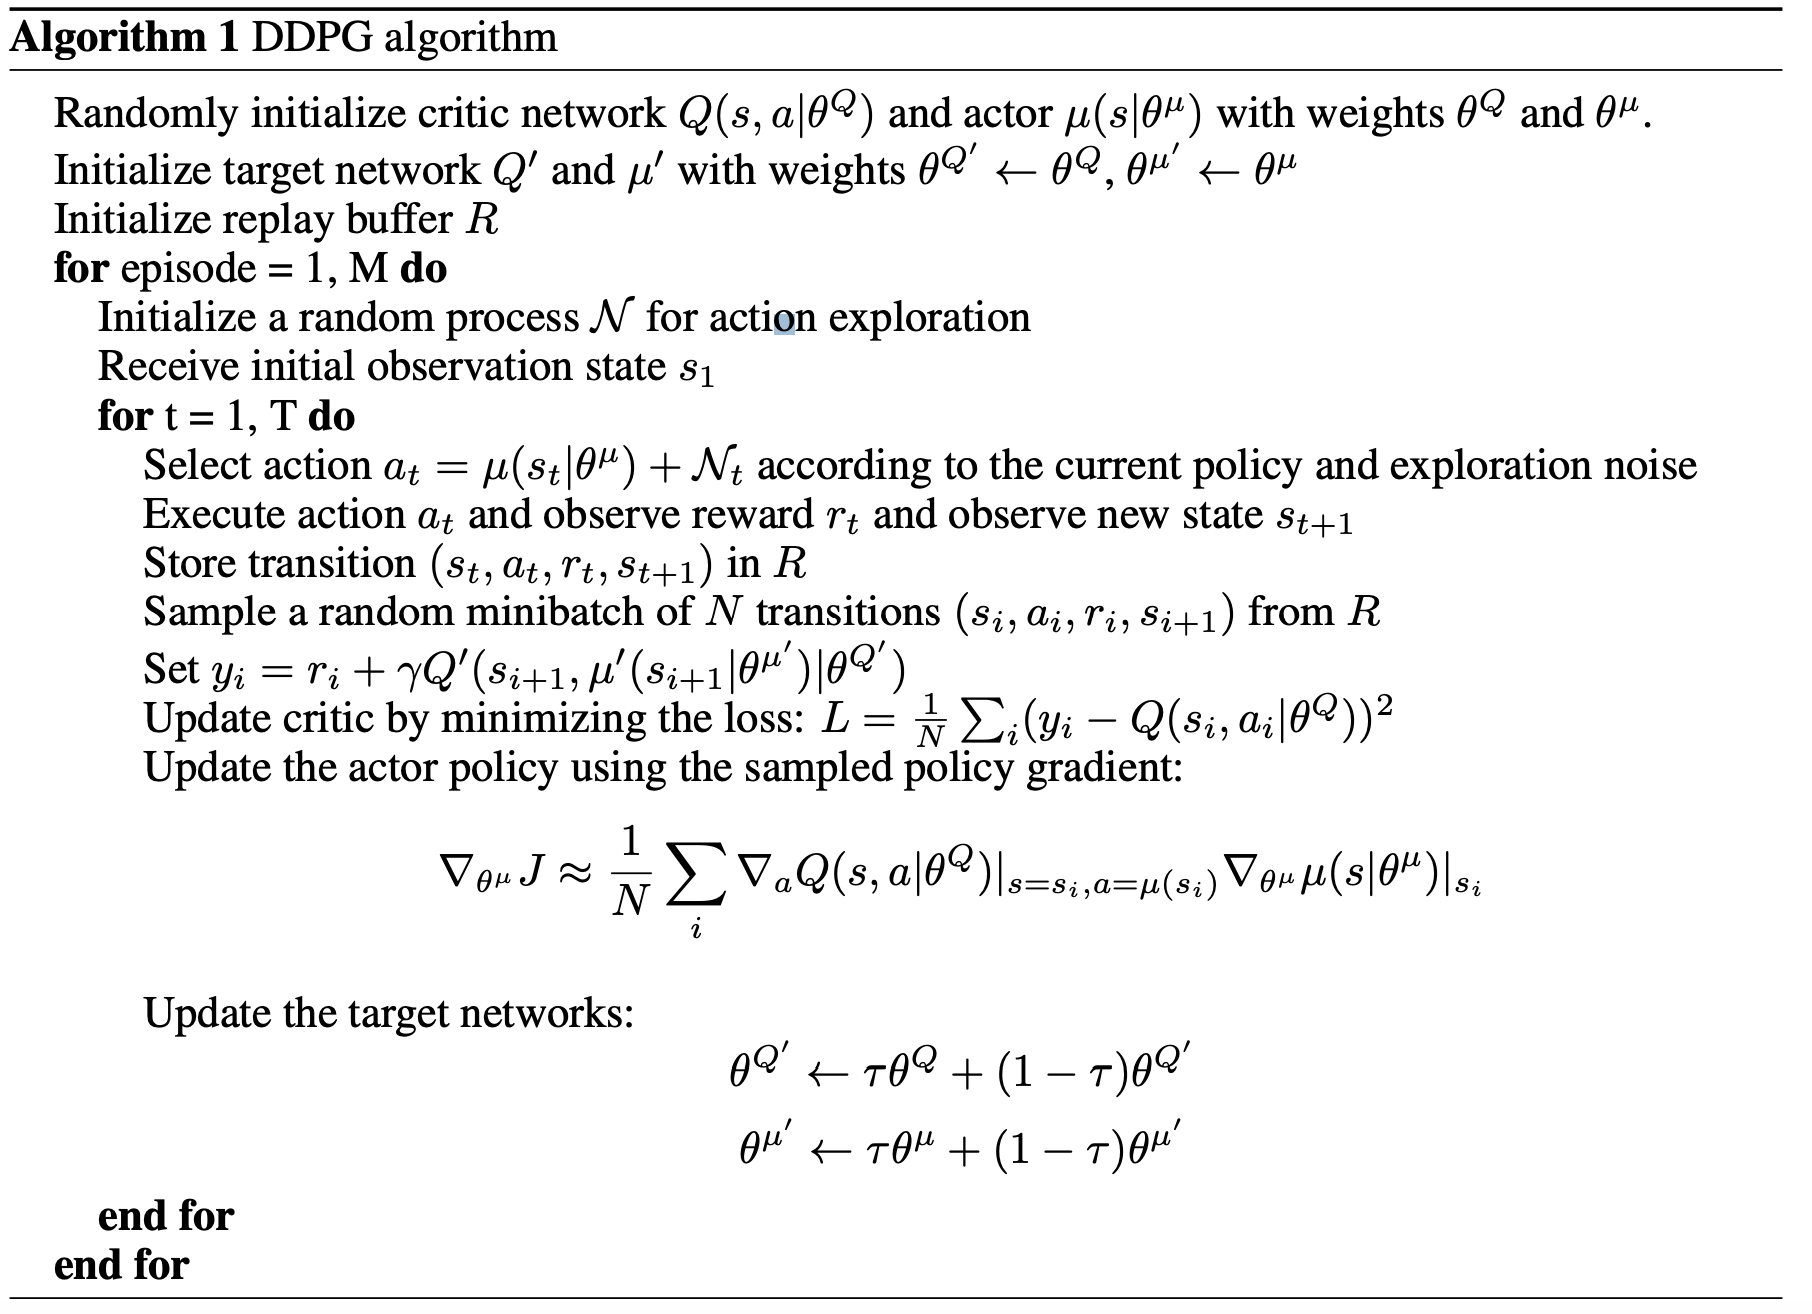

In [315]:
import copy
import random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [304]:
"""
Actor network / policy. By default it is a simple MLP but architecture but optionally can be set by user.
User can also design their own Actor class and use any other DNN architecture like CNN etc.
""" 
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dims=[320, 320]):
        super(Actor, self).__init__()
        self.layers = []
        for i, h in enumerate(hidden_dims):
            if i == 0:
                self.layers.append(nn.Linear(state_dim, h))
            else:
                self.layers.append(nn.Linear(hidden_dims[i-1], h))
        self.layers.append(nn.Linear(hidden_dims[-1], action_dim))
        self.layers = nn.ModuleList(self.layers)
        self.max_action = max_action

    def forward(self, state):
        out = None
        for i in range(len(self.layers)-1):
            if i == 0:
                out = F.relu(self.layers[0](state))
            else:
                out = F.relu(self.layers[i](out))
        return self.max_action * torch.tanh(self.layers[-1](out))

In [305]:
"""
Critic network / policy. By default it is a simple MLP but architecture but optionally can be set by user.
User can also design their own Actor class and use any other DNN architecture like CNN etc.
""" 
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[320, 320]):
        super(Critic, self).__init__()
        self.layers = []
        for i, h in enumerate(hidden_dims):
            if i == 0:
                self.layers.append(nn.Linear(state_dim+action_dim, h))
            else:
                self.layers.append(nn.Linear(hidden_dims[i-1], h))
        self.layers.append(nn.Linear(hidden_dims[-1], action_dim))
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, state, action):
        out = None
        for i in range(len(self.layers)-1):
            if i == 0:
                out = F.relu(self.layers[0](torch.cat([state, action], 1)))
            else:
                out = F.relu(self.layers[i](out))
        return self.layers[-1](out)

In [306]:
class DDPG():
    def __init__(self, state_dim, action_dim, max_action, critic_wd=1e-2, actor_wd=0, critic_lr=0.001, 
                 actor_lr=0.0001, discount=0.99, tau=0.001, actor_hdims=[320,320], critic_hdims=[320,320], 
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        self.actor = Actor(state_dim, action_dim, max_action, actor_hdims)
        self.actor = self.actor.to(device)
        self.target_actor = copy.deepcopy(self.actor)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=actor_lr, weight_decay=actor_wd)
        
        self.critic = Critic(state_dim, action_dim, critic_hdims)
        self.critic = self.critic.to(device)
        self.target_critic = copy.deepcopy(self.critic)
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=critic_lr, weight_decay=critic_wd)
        
        self.discount, self.tau, self.device = discount, tau, device
        
    def get_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        return self.actor(state).cpu().data.numpy().flatten()
    
    def train(self, replay_buffer, batch_size=32):
        # Sample from replay buffer 
        state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

        # Get the target Q value
        # Target_Q_Value = r + ()
        targetQ = self.target_critic(next_state, self.target_actor(next_state))
        targetQ = reward + (not_done * self.discount * targetQ).detach()

        # Get current Q estimate
        current_Q = self.critic(state, action)

        # Compute and optimize critic loss 
        critic_loss = F.mse_loss(current_Q, targetQ)
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        # Compute and Optimize actor loss
        actor_loss = -self.critic(state, self.actor(state)).mean()
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

        # Update the  target models
        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_optim.state_dict(), filename + "_critic_optimizer")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_optim.state_dict(), filename + "_actor_optimizer")


    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_optim.load_state_dict(torch.load(filename + "_critic_optimizer"))
        self.target_critic = copy.deepcopy(self.critic)

        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_optim.load_state_dict(torch.load(filename + "_actor_optimizer"))
        self.target_actor = copy.deepcopy(self.actor)

In [307]:
class ReplayBuffer(object):
    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0

        self.state = np.zeros((max_size, state_dim))
        self.action = np.zeros((max_size, action_dim))
        self.next_state = np.zeros((max_size, state_dim))
        self.reward = np.zeros((max_size, 1))
        self.not_done = np.zeros((max_size, 1))

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    def add(self, state, action, next_state, reward, done):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, size=batch_size)

        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.FloatTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device)
        )

In [308]:
def run_ddpg(env_name, min_timesteps, total_timesteps, critic_wd=1e-2, actor_wd=0, critic_lr=0.001, 
             actor_lr=0.0001, bs=32, actor_hdims=[320, 320], critic_hdims=[320,320], discount=0.99, tau=0.001, 
             seed=7, exploration_noise=0.1, noise_decay_rate=0.99):
    #create gym environment
    env = gym.make(env_name)

    # Seeding
    #env.seed(seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    #Get environment parameters
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0] 
    max_action = float(env.action_space.high[0])
    
    #Create DDPG policies
    policy = DDPG(state_dim, action_dim, max_action, critic_wd, actor_wd, critic_lr, actor_lr, discount, tau, 
                  actor_hdims, critic_hdims)
    
    #Instantiate empty replay buffer
    replay_buffer = ReplayBuffer(state_dim, action_dim)
    
    # Environment and reward record setup
    state, _ = env.reset()
    done = False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    reward_records = []
    
    #Train for total_timesteps
    for t in range(int(total_timesteps)):

        episode_timesteps += 1

        # Select action according to policy with some exploration noise
        action = (
            policy.get_action(np.array(state))
            + np.random.normal(0, max_action * exploration_noise, size=action_dim)
        ).clip(-max_action, max_action)
        
        #Decay exploration noise over time
        exploration_noise *= noise_decay_rate
        
        # Execute action and update replay buffer
        next_state, reward, done, trunc, _ = env.step(action) 
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0
        replay_buffer.add(state, action, next_state, reward, done_bool)
        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if t >= min_timesteps:
            policy.train(replay_buffer, bs)
        
        # Episode ended, reset environment and log episode reward
        if done or trunc: 
            print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
            state, _ = env.reset()
            done = False
            reward_records.append(episode_reward)
            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1
            
        
    return policy, reward_records

In [309]:
def eval_policy(policy, env_name, eval_seed=17, num_eval_episodes=10):
    eval_env = gym.make(env_name)
    #eval_env.seed(eval_seed)
    
    reward_list = []
    avg_reward = 0.
    for ep in range(num_eval_episodes):
        print(f"Running episode {ep+1}")
        state, _ = eval_env.reset()
        done, trunc = False, False
        ep_rew = 0
        while not done and not trunc:
            action = policy.get_action(np.array(state))
            state, reward, done, trunc, _ = eval_env.step(action)
            ep_rew += reward
            
        avg_reward += ep_rew
        reward_list.append(ep_rew)
    avg_reward /= num_eval_episodes

    print(f"Evaluation over {num_eval_episodes} episodes: {avg_reward:.3f}")
    print(f"Rewards across {num_eval_episodes}: {reward_list}")
    return avg_reward, reward_list

# DDPG Demo on Pendulum-v1 Gym Environment

In [310]:
#Hyperparamters
env_name = "Pendulum-v1"
min_timesteps = 25e3
total_timesteps = 1e5
tau = 0.005
bs=64

In [311]:
trained_ddpg_policy, reward_records = run_ddpg(env_name, min_timesteps, total_timesteps, tau=tau, bs=64)
trained_ddpg_policy.save("DDPG_Pendulum_v1")

/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1179.661
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1579.405
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1280.274
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1671.752
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1150.812
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1286.437
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1258.677
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1175.690
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1669.524
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1721.522
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1467.037
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1164.978
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1084.541
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1071.380
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -1181.122
Total T: 3200 Episode Num: 16 Episode T: 200 Reward: -922.410
Total 

Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -1056.684
Total T: 26200 Episode Num: 131 Episode T: 200 Reward: -1124.195
Total T: 26400 Episode Num: 132 Episode T: 200 Reward: -1184.618
Total T: 26600 Episode Num: 133 Episode T: 200 Reward: -1064.860
Total T: 26800 Episode Num: 134 Episode T: 200 Reward: -1106.539
Total T: 27000 Episode Num: 135 Episode T: 200 Reward: -782.870
Total T: 27200 Episode Num: 136 Episode T: 200 Reward: -866.669
Total T: 27400 Episode Num: 137 Episode T: 200 Reward: -597.425
Total T: 27600 Episode Num: 138 Episode T: 200 Reward: -267.189
Total T: 27800 Episode Num: 139 Episode T: 200 Reward: -278.946
Total T: 28000 Episode Num: 140 Episode T: 200 Reward: -141.628
Total T: 28200 Episode Num: 141 Episode T: 200 Reward: -7.521
Total T: 28400 Episode Num: 142 Episode T: 200 Reward: -244.507
Total T: 28600 Episode Num: 143 Episode T: 200 Reward: -125.719
Total T: 28800 Episode Num: 144 Episode T: 200 Reward: -123.883
Total T: 29000 Episode Num: 145 Episo

Total T: 51800 Episode Num: 259 Episode T: 200 Reward: -120.096
Total T: 52000 Episode Num: 260 Episode T: 200 Reward: -247.612
Total T: 52200 Episode Num: 261 Episode T: 200 Reward: -239.229
Total T: 52400 Episode Num: 262 Episode T: 200 Reward: -129.734
Total T: 52600 Episode Num: 263 Episode T: 200 Reward: -130.834
Total T: 52800 Episode Num: 264 Episode T: 200 Reward: -129.782
Total T: 53000 Episode Num: 265 Episode T: 200 Reward: -118.404
Total T: 53200 Episode Num: 266 Episode T: 200 Reward: -249.729
Total T: 53400 Episode Num: 267 Episode T: 200 Reward: -235.927
Total T: 53600 Episode Num: 268 Episode T: 200 Reward: -246.577
Total T: 53800 Episode Num: 269 Episode T: 200 Reward: -120.372
Total T: 54000 Episode Num: 270 Episode T: 200 Reward: -1.191
Total T: 54200 Episode Num: 271 Episode T: 200 Reward: -238.083
Total T: 54400 Episode Num: 272 Episode T: 200 Reward: -118.848
Total T: 54600 Episode Num: 273 Episode T: 200 Reward: -121.621
Total T: 54800 Episode Num: 274 Episode T:

Total T: 77600 Episode Num: 388 Episode T: 200 Reward: -127.279
Total T: 77800 Episode Num: 389 Episode T: 200 Reward: -2.682
Total T: 78000 Episode Num: 390 Episode T: 200 Reward: -229.666
Total T: 78200 Episode Num: 391 Episode T: 200 Reward: -127.261
Total T: 78400 Episode Num: 392 Episode T: 200 Reward: -122.777
Total T: 78600 Episode Num: 393 Episode T: 200 Reward: -223.588
Total T: 78800 Episode Num: 394 Episode T: 200 Reward: -231.279
Total T: 79000 Episode Num: 395 Episode T: 200 Reward: -338.272
Total T: 79200 Episode Num: 396 Episode T: 200 Reward: -244.417
Total T: 79400 Episode Num: 397 Episode T: 200 Reward: -1.506
Total T: 79600 Episode Num: 398 Episode T: 200 Reward: -1.849
Total T: 79800 Episode Num: 399 Episode T: 200 Reward: -0.946
Total T: 80000 Episode Num: 400 Episode T: 200 Reward: -239.455
Total T: 80200 Episode Num: 401 Episode T: 200 Reward: -119.302
Total T: 80400 Episode Num: 402 Episode T: 200 Reward: -344.299
Total T: 80600 Episode Num: 403 Episode T: 200 R

In [312]:
eval_avg_reward, eval_reward_list = eval_policy(trained_ddpg_policy, env_name)

Running episode 1
Running episode 2
Running episode 3
Running episode 4
Running episode 5
Running episode 6
Running episode 7
Running episode 8
Running episode 9
Running episode 10
Evaluation over 10 episodes: -153.930
Rewards across 10: [-2.0164180252345942, -235.08761974116834, -117.83611434518639, -124.99665128557034, -121.50923381338933, -129.0811898064259, -119.3045926657005, -339.0222145223842, -229.96909963331152, -120.4807872869776]


# Plot Training Results

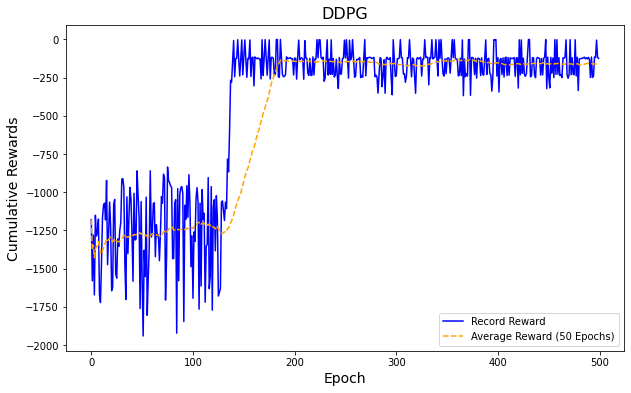

In [314]:
import matplotlib.pyplot as plt

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    if idx < 50:
        avg_list = reward_records[:idx + 1]
    else:
        avg_list = reward_records[idx - 49:idx + 1]
    average_reward.append(np.average(avg_list))

# Plot both reward records and average rewards
plt.figure(figsize=(10, 6))
plt.plot(reward_records, label='Record Reward', color='blue')
plt.plot(average_reward, label='Average Reward (50 Epochs)', color='orange', linestyle='--')

# Add title and labels
plt.title('DDPG', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Cumulative Rewards', fontsize=14)

# Add legend
plt.legend(loc='lower right')

# Save and show the plot
plt.savefig('ddpg_returns.png', dpi=300)
plt.show()